In [2]:
import re
import streamlit as st
import openai as OpenAI
from langchain_core.output_parsers import StrOutputParser
import os


from langchain_core.prompts import(
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    AIMessagePromptTemplate,
    ChatPromptTemplate
)

In [52]:
from dotenv import load_dotenv
load_dotenv()

True

In [42]:
from langchain_openai import ChatOpenAI

llm_engine=ChatOpenAI(temperature=0.6,model_name="gpt-4o")


In [32]:
code_text='''
import streamlit as st
code = st.text_area("Paste your Python code here:", height=300)

submit=st.button("Ask the question")
print(code)
if submit:
    with st.spinner("Thinking"):
        st.subheader("Response is:")

'''

In [48]:
from langchain.prompts import PromptTemplate
template = '''
You will be provided with a piece of code, and your task is to explain it in a concise way
Given input code:
    {code}
'''

prompt=PromptTemplate(input_variables=["code"],
                        template=template)

In [49]:
prompt.format(code=code_text)

'\nYou will be provided with a piece of code, and your task is to explain it in a concise way\nGiven input code:\n    \nimport streamlit as st\ncode = st.text_area("Paste your Python code here:", height=300)\n\nsubmit=st.button("Ask the question")\nprint(code)\nif submit:\n    with st.spinner("Thinking"):\n        st.subheader("Response is:")\n\n\n'

In [60]:

from langchain.chains import LLMChain
chain=LLMChain(llm=llm_engine,prompt=prompt,output_key="documentation")

In [51]:
chain.run(code=code_text)

'This code creates a simple web application using Streamlit, a Python library for building interactive web apps. Here\'s a breakdown of the code:\n\n1. **Import Streamlit**: `import streamlit as st` imports the Streamlit library, which is used to create the web app.\n\n2. **Text Area for Code Input**: `code = st.text_area("Paste your Python code here:", height=300)` creates a text area on the web page where users can paste their Python code. The `height=300` specifies the height of the text area.\n\n3. **Submit Button**: `submit = st.button("Ask the question")` creates a button labeled "Ask the question". When this button is clicked, it triggers the subsequent logic in the code.\n\n4. **Print Code**: `print(code)` prints the content of the text area to the console or logs. This is mainly for debugging or logging purposes.\n\n5. **Conditional Logic on Button Click**: `if submit:` checks if the submit button has been clicked.\n\n   - **Spinner**: `with st.spinner("Thinking"):` displays a

In [53]:
from langchain_huggingface import HuggingFaceEndpoint

llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct",
    temperature= 0.7,
    max_new_tokens=1000,
    task="text-generation",
)

In [66]:
prompt_detailed_text = PromptTemplate(
    input_variables=['documentation'],
    template='''
        The following text provides an explanation of a piece of code. Your task is to refine, expand, and improve this documentation by:
        
        - Breaking down the explanation into clear sections with appropriate headings.
        - Providing additional details, including definitions of relevant concepts.
        - Adding real-world examples and potential use cases.
        - Explaining why each step is important.
        - Maintaining technical accuracy and clarity without introducing incorrect information.

        Here is the original explanation:
        {documentation}

        Now, generate an expanded, well-structured, and comprehensive version of the documentation.
    '''
)

In [70]:

mistrial_chain=LLMChain(llm=llm_engine,prompt=prompt_detailed_text,output_key="bigdoc")

In [71]:
from langchain.chains import SequentialChain

final_chain = SequentialChain(chains=[chain,mistrial_chain],
                              input_variables=['code'],
                              output_variables=['documentation','bigdoc'],
                              return_all=True)


In [72]:
final_chain({'code':code_text})

{'code': '\nimport streamlit as st\ncode = st.text_area("Paste your Python code here:", height=300)\n\nsubmit=st.button("Ask the question")\nprint(code)\nif submit:\n    with st.spinner("Thinking"):\n        st.subheader("Response is:")\n\n',
 'documentation': 'This code creates a simple web application using the Streamlit library, which is designed for building interactive web apps for data science and machine learning. Here\'s a concise explanation of what each part of the code does:\n\n1. **Import Streamlit**: It imports the Streamlit library, which is used to build the web app.\n\n2. **Text Area for Code Input**: `st.text_area()` creates a text area input widget on the web page where users can paste their Python code. The text area is labeled "Paste your Python code here:" and has a specified height of 300 pixels.\n\n3. **Submit Button**: `st.button()` creates a button labeled "Ask the question" on the web page. When this button is clicked, it triggers the actions defined in the su

In [73]:
Chat="Beginner"

In [78]:
# Level-specific instructions dictionary
level_instructions = {
    "Beginner": {
        "specific_instructions": """
        - Break down every line of code into simple, plain English
        - Define all technical terms, even basic programming concepts
        - Use analogies and real-world examples for complex concepts
        - Include step-by-step explanations with comments
        - Explain the 'why' behind each operation
        - Add warnings about common mistakes and pitfalls
        """,
        "additional_guidelines": """
        - Use simple vocabulary and avoid technical jargon where possible
        - Include visual explanations or ASCII diagrams when helpful
        - Provide multiple examples starting with the simplest use case
        - Link to basic tutorials and learning resources
        - Include practice exercises and sample modifications
        """
    },
    "Intermediate": {
        "specific_instructions": """
        - Focus on key functionality and important implementation details
        - Explain advanced concepts and design patterns when relevant
        - Highlight best practices and efficiency considerations
        - Include moderate-level optimization suggestions
        - Discuss error handling and edge cases
        """,
        "additional_guidelines": """
        - Balance between detailed explanations and concise documentation
        - Include practical examples with real-world scenarios
        - Reference related concepts and alternative approaches
        - Discuss performance implications
        - Suggest ways to extend or modify the code
        """
    },
    "Expert": {
        "specific_instructions": """
        - Focus on high-level architecture and design decisions
        - Highlight complex edge cases and performance considerations
        - Document any non-obvious implementations or optimizations
        - Include relevant algorithm complexity analysis
        - Focus on scalability and maintenance aspects
        """,
        "additional_guidelines": """
        - Keep explanations concise and technically precise
        - Reference advanced documentation and relevant papers
        - Discuss system-level implications and integration considerations
        - Include benchmark comparisons when relevant
        - Focus on optimization opportunities and trade-offs
        """
    }
}

# Base template that takes level as an input variable
template = """
You are a code documentation creator tailored for {level} level programmers.
The user provides a piece of code. Your task is to create appropriate documentation with the following considerations:

{specific_instructions}

Base requirements for all levels:
- Maintain technical accuracy
- Focus on clarity and relevance
- Suggest optimization improvements
- Provide a revised code sample at the end

Additional guidelines:
{additional_guidelines}

Please generate documentation that matches this expertise level.
"""

# Create the system message template
system_prompt = SystemMessagePromptTemplate.from_template(
    template,
    partial_variables={
        "level": Chat,
        "specific_instructions": level_instructions[Chat]["specific_instructions"],
        "additional_guidelines": level_instructions[Chat]["additional_guidelines"]
    }
)

In [80]:
system_prompt.format(Chat=Chat)

SystemMessage(content="\nYou are a code documentation creator tailored for Beginner level programmers.\nThe user provides a piece of code. Your task is to create appropriate documentation with the following considerations:\n\n\n        - Break down every line of code into simple, plain English\n        - Define all technical terms, even basic programming concepts\n        - Use analogies and real-world examples for complex concepts\n        - Include step-by-step explanations with comments\n        - Explain the 'why' behind each operation\n        - Add warnings about common mistakes and pitfalls\n        \n\nBase requirements for all levels:\n- Maintain technical accuracy\n- Focus on clarity and relevance\n- Suggest optimization improvements\n- Provide a revised code sample at the end\n\nAdditional guidelines:\n\n        - Use simple vocabulary and avoid technical jargon where possible\n        - Include visual explanations or ASCII diagrams when helpful\n        - Provide multiple e

In [89]:
level="Beginner"
task="Optimization Suggestions"


In [87]:
level_instructions = {
    "Beginner": {
        "specific_instructions": """
        - Break down every line of code into simple, plain English
        - Define all technical terms, even basic programming concepts
        - Use analogies and real-world examples for complex concepts
        - Include step-by-step explanations with comments
        - Explain the 'why' behind each operation
        - Add warnings about common mistakes and pitfalls
        """,
        "additional_guidelines": """
        - Use simple vocabulary and avoid technical jargon where possible
        - Include visual explanations or ASCII diagrams when helpful
        - Provide multiple examples starting with the simplest use case
        - Link to basic tutorials and learning resources
        """
    },
    "Intermediate": {
        "specific_instructions": """
        - Focus on key functionality and important implementation details
        - Explain advanced concepts and design patterns when relevant
        - Discuss error handling and edge cases
        """,
        "additional_guidelines": """
        - Balance between detailed explanations and concise documentation
        - Include practical examples with real-world scenarios
        - Reference related concepts and alternative approaches
        - Discuss performance implications
        """
    },
    "Expert": {
        "specific_instructions": """
        - Focus on high-level architecture and design decisions
        - Highlight complex edge cases and performance considerations
        - Document any non-obvious implementations or optimizations
        - Include relevant algorithm complexity analysis
        - Focus on scalability and maintenance aspects
        """,
        "additional_guidelines": """
        - Keep explanations concise and technically precise
        - Reference advanced documentation and relevant papers
        - Discuss system-level implications and integration considerations
        - Include benchmark comparisons when relevant
        - Focus on optimization opportunities and trade-offs
        """
    }
}

prompt_templates = {
    "General Code Explanation": """
        You are a code documentation expert. Explain the given code in detail to the {level} level programmers:
        
        {specific_instructions}

        Base requirements for all levels:
        - Maintain technical accuracy
        - Focus on clarity and relevance
        - Suggest optimization improvements
        - Provide a revised code sample at the end

        Additional guidelines:
        {additional_guidelines}

Please generate documentation that matches this expertise level and in a detailed manner .
    """,
    "Optimization Suggestions": """
        Analyze the provided code and suggest optimizations for {level} level programmers:
        - Performance improvements
        - Memory management
        - Readability enhancements
        - Highlight best practices and efficiency considerations
        - Include moderate-level optimization suggestions
    Please generate documentation that matches this expertise level and in a detailed manner
    """,
    "Bug Detection and Fixes": """
        Review the given code and identify potential bugs for {level} level programmers. Provide:
        - Explanation of the issues
        - Suggested fixes with corrected code snippets
        - Focus on Tradeoffs when chaning the code
    Please generate documentation that matches this expertise level and in a detailed manner
    """,
    "Security Vulnerability Analysis": """
        Examine the provided code for security vulnerabilities for {level} level programmers. Cover:
        - Possible security threats
        - Best practices for secure coding
        - Recommendations to fix vulnerabilities
    Please generate documentation that matches this expertise level and in a detailed manner
    """,
    "Best Practices Recommendations": """
        Evaluate the code against software engineering best practices for {level} level programmers. Offer:
        - Clean coding guidelines
        - Maintainability improvements
    Please generate documentation that matches this expertise level and in a detailed manner
    """
}


In [93]:
if task=="General Code Explanation":
    system_prompt = SystemMessagePromptTemplate.from_template(
    prompt_templates[task],
    partial_variables={
        "level": level,
        "specific_instructions": level_instructions[level]["specific_instructions"],
        "additional_guidelines": level_instructions[level]["additional_guidelines"]
    })
else:
    system_prompt = SystemMessagePromptTemplate.from_template(
    prompt_templates[task],
    partial_variables={
        "level": level,
    })


In [94]:
system_prompt.format(level=level,task=task)

SystemMessage(content='\n        Analyze the provided code and suggest optimizations for Beginner level programmers:\n        - Performance improvements\n        - Memory management\n        - Readability enhancements\n        - Highlight best practices and efficiency considerations\n        - Include moderate-level optimization suggestions\n    Please generate documentation that matches this expertise level and in a detailed manner\n    ', additional_kwargs={}, response_metadata={})

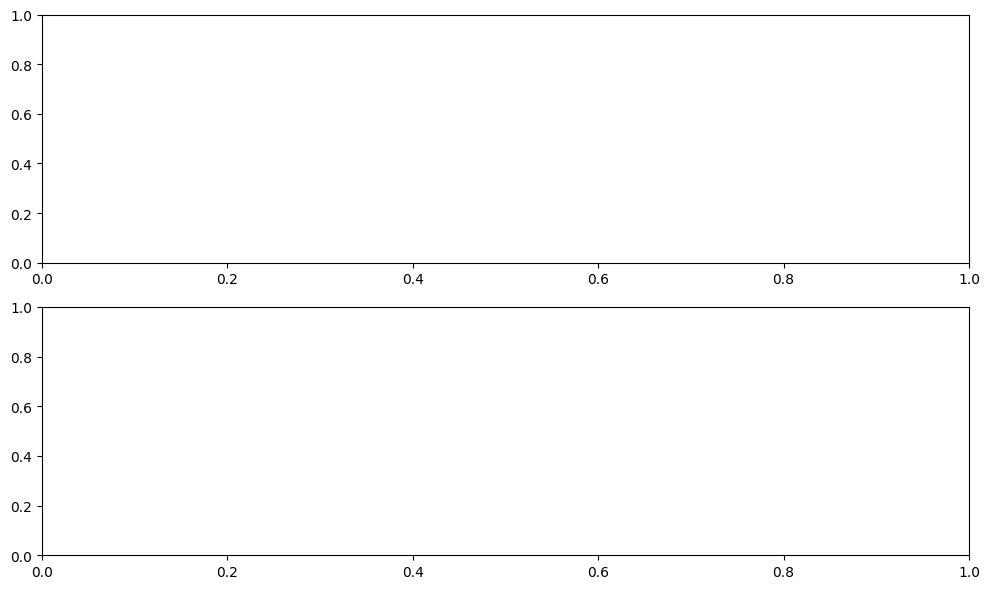

In [101]:
import psutil
import time
import matplotlib.pyplot as plt
import threading
from matplotlib.animation import FuncAnimation

# Initialize lists to store metrics
timestamps = []
cpu_usage = []
memory_usage = []

start_time = time.time()

# Lock for thread-safe access to shared resources
lock = threading.Lock()

def update_plot(frame):
    with lock:
        current_time = time.time() - start_time
        timestamps.append(current_time)
        
        # Ensure CPU and Memory data is collected correctly
        cpu_percent = psutil.cpu_percent(interval=None)  # Remove interval to get instant value
        mem_percent = psutil.virtual_memory().percent
        
        cpu_usage.append(cpu_percent)
        memory_usage.append(mem_percent)
        print(f"CPU: {cpu_percent}%, Memory: {mem_percent}%")

        # Keep the last 50 points
        if len(timestamps) > 50:
            timestamps.pop(0)
            cpu_usage.pop(0)
            memory_usage.pop(0)

        ax1.clear()
        ax2.clear()

        ax1.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage (%)")
        ax1.set_title("CPU Utilization Over Time")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("CPU Usage (%)")
        ax1.legend()
        ax1.grid(True)

        ax2.plot(timestamps, memory_usage, marker='s', linestyle='-', color='r', label="Memory Usage (%)")
        ax2.set_title("Memory Utilization Over Time")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Memory Usage (%)")
        ax2.legend()
        ax2.grid(True)


# Function to execute the given code
def execute_code(code):
    try:
        exec(code)  # Execute the provided Python code
    except Exception as e:
        print(f"Error in executing code: {e}")

# Start a separate thread to run the given code
def run_code_in_thread(code):
    thread = threading.Thread(target=execute_code, args=(code,))
    thread.start()

# Create the Matplotlib figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Use FuncAnimation to update the plot dynamically
ani = FuncAnimation(fig, update_plot, interval=500, cache_frame_data=False)  # Update every 500ms

# Run the given code and start plotting
user_code = """
for i in range(10**6):
    x = i**2  # Simulating CPU workload
"""
# Start executing the user code
run_code_in_thread(user_code)

# Start the animation after starting the thread
plt.tight_layout()
plt.show()